In [1]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
%matplotlib inline

import sys
sys.path.append('../repo/d-script/')
# d-script imports
from data_iters.minibatcher import MiniBatcher
from data_iters.iam_hdf5_iterator import IAM_MiniBatcher

Using gpu device 0: GeForce GTX 980M (CNMeM is disabled)


### Word level document sharding
#### Be sure to set use_form=True due to HDF5 structure

In [2]:
hdf5_file = '/memory/author_lines.hdf5'
num_authors=50
# num_forms_per_author=-1
num_forms_per_author=50
shingle_dim=(120,1909)
shingle_dim=(120,120)
use_form=True

batch_size=32
lr = 0.01
total_iters=1000

### Call the minibatcher and check the data

Shape=(640, 120, 120), Max=0.945098042488


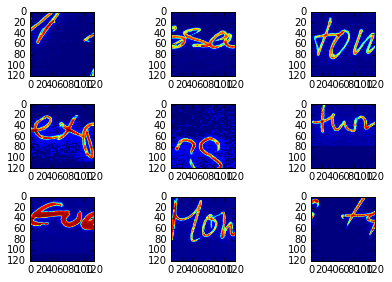

In [3]:
iam_m = IAM_MiniBatcher(hdf5_file, num_authors, num_forms_per_author, shingle_dim=shingle_dim, use_form=use_form, default_mode=MiniBatcher.TRAIN, batch_size=batch_size)

[X_test, Y_test] = iam_m.get_train_batch(batch_size*20)
print "Shape="+str(X_test.shape)+", Max="+str(X_test.max())

plt.clf
plt.subplots(3,3)
plt.tight_layout()
s = np.random.choice(32,9, replace=False)

for i in xrange(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[s[i]])

### Build the neural network model

In [4]:
if True:
    model = Sequential()
    model.add(Convolution2D(48, 12, 12,
                        border_mode='valid',
                        input_shape=(1, shingle_dim[0], shingle_dim[1])))

    model.add(BN())
    #model.add(PReLU())
    model.add(Activation('relu'))

    model.add(Convolution2D(48, 6, 6))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.25))

    model.add(Convolution2D(128, 6, 6, border_mode = 'valid'))
    model.add(BN())
    model.add(Activation('relu'))
    #    model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #    #model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode = 'valid'))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(PReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BN())
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(BN())
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))

    model.add(Dense(num_authors))
    model.add(Activation('softmax'))

    print "Compiling model"
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.7, nesterov=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    print "Finished compilation"


if False:
    model = Sequential()
    model.add(Convolution2D(48, 12, 12,
                        border_mode='valid',
                        input_shape=(1, shingle_dim[0], shingle_dim[1]),
                        activation='relu'))

    model.add(Convolution2D(48, 6, 6, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, 6, 6, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.5))

    model.add(Convolution2D(128, 4, 4, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, 3, 3, border_mode = 'valid', activation='relu'))
    #model.add(BN(epsilon=1e-6))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_authors))
    model.add(Activation('softmax'))

    print "Compiling model"
    sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd)
    print "Finished compilation"

print "Getting the first testing batch"
[X_val, Y_val] = iam_m.get_val_batch(batch_size*10)
X_val = np.expand_dims(X_val, 1)
Y_val = to_categorical(Y_val, num_authors)
print "Finished getting "+str(batch_size*10)+" data points"

Compiling model
Finished compilation
Getting the first testing batch
Finished getting 320 data points


In [ ]:
from PIL import Image
def randangle(batch):
    newbatch = np.zeros(batch.shape)
    for i,im in enumerate(batch):
        imangle = np.asarray(Image.fromarray(im.squeeze()).rotate(7.5*np.random.randn()))
        newbatch[i]=imangle
    return newbatch

In [ ]:
for batch_iter in xrange(total_iters):
    [X_train, Y_train] = iam_m.get_train_batch(batch_size*100)
    X_train = np.expand_dims(X_train, 1)
    X_train = randangle(X_train)
    Y_train = to_categorical(Y_train, num_authors)
    print "Batch iteration "+str(batch_iter)+"/"+str(total_iters)+" on "+str(num_authors)+" authors."
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=1, show_accuracy=True, verbose=1, validation_data=(X_val, Y_val))
    if (batch_iter % 100)==0 and batch_iter != 0:
        model.save_weights('fielnet.hdf5', overwrite=True)

Batch iteration 0/1000 on 50 authors.
Train on 3200 samples, validate on 320 samples
Epoch 1/1
2848/3200 [=========================>....] - ETA: 4s - loss: 3.8654 - acc: 0.0365

In [ ]:
[X_test, Y_test] = iam_m.get_test_batch(batch_size*10)
X_test = np.expand_dims(X_test,1)
Y_test = to_categorical(Y_test, num_authors)
model.evaluate(X_test, Y_test, batch_size=32, show_accuracy=True, verbose=1)

In [ ]:
iam_m.